In [1]:
import os
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from pycm import *
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score


In [2]:
os.chdir(r'C:\Users\c2098580\OneDrive - Cardiff University\Documents\MSc Data Science and Analytics/Dissertation/clean_data')
# read data
mobility_df = pd.read_csv('mobility_df.csv')
selfcare_df = pd.read_csv('selfcare_df.csv')
usualactivities_df = pd.read_csv('usualactivities_df.csv')
paindiscomfort_df = pd.read_csv('paindiscomfort_df.csv')
anxietydepression_df = pd.read_csv('anxietydepression_df.csv')
vas_df = pd.read_csv('vas_df.csv')

# Data preprocessing

In [3]:
for i in mobility_df.columns:
    print(mobility_df[i].value_counts())


256    1
255    1
94     1
93     1
92     1
      ..
166    1
165    1
164    1
163    1
1      1
Name: Unnamed: 0, Length: 256, dtype: int64
1    217
4     37
8      2
Name: Number.of.Procedures, dtype: int64
1.5     9
2.7     9
1.3     8
3.3     8
4.1     7
       ..
34.6    1
9.4     1
18.9    1
84.4    1
12.5    1
Name: Pre.op.PPOSSUM.mortality, Length: 141, dtype: int64
0       9
350     4
1361    4
1735    4
1486    3
       ..
1430    1
919     1
150     1
1703    1
1164    1
Name: WIMD.2019.Rank, Length: 178, dtype: int64
97     11
89     10
106     9
120     9
118     8
       ..
128     1
125     1
124     1
160     1
166     1
Name: Hb.closest.to.discharge.death, Length: 70, dtype: int64
2    113
3     89
4     28
1     25
5      1
Name: ASA.score, dtype: int64
2    119
3     53
4     47
1     37
Name: Pre.Op.risk.category.1, dtype: int64
1    113
3     58
2     47
4     34
5      4
Name: Mobility, dtype: int64
0    220
1     36
Name: Chronic.Pain.issues_1, dtype: int64
0  

In [4]:
# drop Unnamed column
mobility_df = mobility_df.drop('Unnamed: 0',axis=1)
selfcare_df = selfcare_df.drop('Unnamed: 0',axis=1)
usualactivities_df = usualactivities_df.drop('Unnamed: 0',axis=1)
paindiscomfort_df = paindiscomfort_df.drop('Unnamed: 0',axis=1)
anxietydepression_df = anxietydepression_df.drop('Unnamed: 0',axis=1)

In [5]:
five_mob = mobility_df.loc[mobility_df['Mobility']==5,:]

five_mob.isnull().mean()[five_mob.isnull().mean()>0]

Series([], dtype: float64)

In [6]:
#remove NANs
mobility_df = mobility_df.dropna(axis=0)

In [7]:
# create arrays for the features and the target variable 
target = mobility_df['Mobility']

# selected features 
features = mobility_df.drop('Mobility',axis=1)

print('Shape of X data:',features.shape)
print('Shape of y data:',target.shape)

Shape of X data: (256, 77)
Shape of y data: (256,)


#  Oversampling (SMOTE)

https://machinelearningmastery.com/multi-class-imbalanced-classification/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5508166/

Class=3, n=58 (22.656%)
Class=1, n=113 (44.141%)
Class=4, n=34 (13.281%)
Class=2, n=47 (18.359%)
Class=5, n=4 (1.562%)


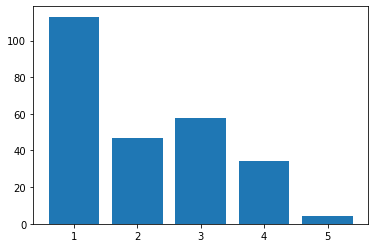

In [8]:

counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# figure related code
fig = plt.figure()
fig.suptitle('Balanced accuracy for considered C values', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(results, labels=names, showmeans=True)

ax.set_xlabel('Considered "C" values')
ax.set_ylabel('Balanced Accuracy')

plt.show()
# plot the distribution
plt


### SMOTE

Class=3, n=113 (20.000%)
Class=1, n=113 (20.000%)
Class=4, n=113 (20.000%)
Class=2, n=113 (20.000%)
Class=5, n=113 (20.000%)


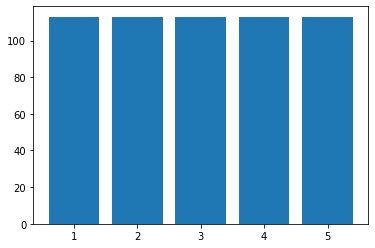

In [9]:
# transform the dataset
oversample = SMOTE(k_neighbors=3)
features_example, target_example = oversample.fit_resample(features, target)
# summarize distribution
counter = Counter(target_example)
for k,v in counter.items():
    per = v / len(target_example) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

# Model- multinomial logistic regression

* The LogisticRegression class can be configured for multinomial logistic regression by setting the “multi_class” argument to “multinomial” and the “solver” argument to a solver that supports multinomial logistic regression, such as “lbfgs“.

* It is a good practice to evaluate classification models using repeated stratified k-fold cross-validation. The stratification ensures that each cross-validation fold has approximately the same distribution of examples in each class as the whole training dataset.



### Define X and y

In [10]:
X = features

y = target

## Standardize

In [11]:
y=np.array(y)

In [12]:
# tune regularization for multinomial logistic regression
# get a list of models to evaluate
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        # create name for model
        key = '%.4f' % p
        # turn off penalty in some cases
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs',class_weight='balanced', penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs',class_weight='balanced', penalty='l2',
                                             C=p)
    return models
 
# evaluate model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
    # define pca
    pca = PCA()
    # create pipeline to scale data and apply pca
    model = Pipeline(steps=[('over', SMOTE(k_neighbors=2)),('under',RandomUnderSampler()),("scaling", StandardScaler()),
                                               ('pca', pca),("model", model)])
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>0.0000 0.215 (0.058)
>0.0001 0.200 (0.029)
>0.0010 0.208 (0.038)
>0.0100 0.201 (0.035)
>0.1000 0.202 (0.044)
>1.0000 0.195 (0.036)


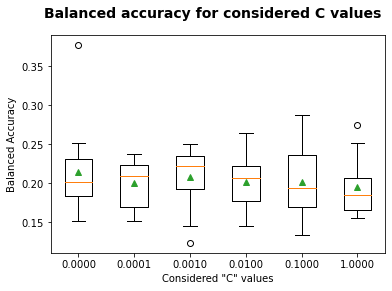

In [15]:

# figure related code
fig = plt.figure()
fig.suptitle('Balanced accuracy for considered C values', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(results, labels=names, showmeans=True)

ax.set_xlabel('Considered "C" values')
ax.set_ylabel('Balanced Accuracy')

plt.show()

### Best model

Best model has C = 0.0001

In [ ]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',C=0.0001,class_weight='balanced')
# define pca
pca = PCA()
# create pipeline to scale data and apply pca
model = Pipeline(steps=[('over', SMOTE(k_neighbors=2)),('under',RandomUnderSampler()),("scaling", StandardScaler()),
                                           ('pca', pca),("model", model)])
# split the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24,stratify=y)

#### Train balanced accuracy

In [ ]:
# fit the model on the training dataset
model.fit(X_train, y_train)
# make a prediction
y_pred = model.predict(X_train)

balanced_accuracy_score(y_train, y_pred)

#### Test balanced accuracy

In [ ]:
# fit the model on the training dataset
model.fit(X_train, y_train)
# make a prediction
y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

In [ ]:
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)

In [ ]:
print(cm)

# Model - neural network

### Define X and y

In [ ]:
X = features

y = target

## Transform

In [ ]:
y=np.array(y)

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='softmax')) # Softmax for multi-class classification
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
    # define pca
    pca = PCA()
    # create pipeline to scale data and apply pca
    model = Pipeline(steps=[('over', SMOTE(k_neighbors=2)),('under',RandomUnderSampler()),("scaling", StandardScaler()),
                                               ('pca', pca),("model", model)])
    # evaluate the model
    scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
    return scores

# hyperparameter tuning for neural network
def get_models():
    models = dict()
    for batch_size in [10, 100]:
        for epochs in [50, 100,200]:
            # create name for model
            key = 'batch_size',batch_size,'epochs',epochs
            # models
            models[key] = KerasClassifier(build_fn=baseline_model, epochs=epochs, batch_size=batch_size, verbose=0)
    return models

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)

In [ ]:
model_name = pd.DataFrame([str(x) for x in names], columns=['model_name'])
accuracy = pd.DataFrame([mean(x) for x in results],columns=['accuracy'])
std = pd.DataFrame([std(x) for x in results],columns=['std'])

#store results
results = pd.concat([model_name, accuracy,std], axis=1, join="inner")
# find best accuracy
print(results.sort_values('accuracy',ascending=False).iloc[0,:])

In [ ]:
# define the multinomial logistic regression model
model = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=100, verbose=0)
# define pca
pca = PCA()
# create pipeline to scale data and apply pca
model = Pipeline(steps=[('over', SMOTE(k_neighbors=2)),('under',RandomUnderSampler()),("scaling", StandardScaler()),
                                           ('pca', pca),("model", model)])
# split the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24,stratify=y)

#### Train balanced accuracy

In [ ]:
# fit the model on the training dataset
model.fit(X_train, y_train)
# make a prediction
y_pred = model.predict(X_train)

balanced_accuracy_score(y_train, y_pred)

#### Test balanced accuracy

In [ ]:
# fit the model on the training dataset
model.fit(X_train, y_train)
# make a prediction
y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

In [ ]:
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)

In [ ]:
print(cm)